---
title: Assignment 04
author:
  - name: JulioVargas
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: '2025-10-07'
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---



# Load the Dataset (1)

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# df.printSchema() # comment this line when rendering the submission
df.show(5)
print(df.count())

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 02:57:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/09 02:57:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

72498


# Feature Engineering (2)

In [2]:
from pyspark.sql.functions import col, pow
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.sql.functions import col, sum as spark_sum, when, trim, length
import hvplot.pandas  # enables hvplot on pandas
from pyspark.sql.functions import countDistinct

import pandas as pd

eda_cols = [
    "SALARY",
    "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP",
    "STATE_NAME", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME", "MAX_EDULEVELS_NAME"
]

df_eda = df.select(eda_cols)
df_eda.show(5, truncate=False)

df_eda = df_eda.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On-Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On-Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

# 0. Heatmap Before missing value treatment
df_eda = df_eda.toPandas()

# create new DataFrame where each cell missing (True) or not (False)
missing_mask = df_eda.isnull()

# Melt into long-form  | 4 columns: index, column, is_missing
missing_long = (
    missing_mask.reset_index()
    .melt(id_vars="index", var_name="column", value_name="is_missing")
)


print(missing_long)

+------+--------------------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+------------------+
|SALARY|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|COMPANY_IS_STAFFING|IS_INTERNSHIP|STATE_NAME|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |MIN_EDULEVELS_NAME |MAX_EDULEVELS_NAME|
+------+--------------------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+------------------+
|NULL  |2                   |2                   |6       |false              |false        |Arkansas  |[None]          |Full-time (> 32 hours)|Bachelor's degree  |NULL              |
|NULL  |3                   |3                   |NULL    |true               |false        |Maine     |Remote          |Full-time (> 32 hours)|No Education Listed|NULL              |
|NULL  |5                   |NULL                |35      |false              |f

        index              column  is_missing
0           0              SALARY        True
1           1              SALARY        True
2           2              SALARY        True
3           3              SALARY        True
4           4              SALARY       False
...       ...                 ...         ...
797473  72493  MAX_EDULEVELS_NAME        True
797474  72494  MAX_EDULEVELS_NAME        True
797475  72495  MAX_EDULEVELS_NAME        True
797476  72496  MAX_EDULEVELS_NAME        True
797477  72497  MAX_EDULEVELS_NAME        True

[797478 rows x 3 columns]


## Chose Data (2.1)

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
## Chose Categorial Columns and continuous 
# Dependent (y): SALARY
# Independent  (X):
# Four numerical/boolean features:
#   MIN_YEARS_EXPERIENCE, DURATION, IS_INTERNSHIP, COMPANY_IS_STAFFING
# Two categorical features:
#   REMOTE_TYPE_NAME, EMPLOYMENT_TYPE_NAME


eda_cols = [
    "SALARY",
    "MIN_YEARS_EXPERIENCE", "DURATION",
    "IS_INTERNSHIP", "COMPANY_IS_STAFFING",
    "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME"
]

df_eda = df.select(eda_cols)

## Missing Value Treatment (2.2)

In [4]:
from pyspark.sql.functions import col, when, isnan, count
from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, expr, median
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
#Cleaning - two categorical features

df_eda = df_eda.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On-Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On-Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

df_eda = df_eda.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

#Cleaning Booleans -  IS_INTERNSHIP, COMPANY_IS_STAFFING
df_eda = df_eda.withColumn("IS_INTERNSHIP", when(col("IS_INTERNSHIP").isNull(), False).otherwise(col("IS_INTERNSHIP")))

df_eda = df_eda.withColumn( "COMPANY_IS_STAFFING",when(col("COMPANY_IS_STAFFING").isNull(), False).otherwise(col("COMPANY_IS_STAFFING")) )

#Cleaning Numericals with median in nulls - DURATION

median_duration = df_eda.approxQuantile("DURATION", [0.5], 0.01)[0]

df_eda = df_eda.withColumn("DURATION",
                            when(col("DURATION").isNull(), median_duration)
                            .otherwise(col("DURATION"))
                        )

#Cleaning Dependent (y) with median by : SALARY

#overall median
overall_median_salary = df_eda.approxQuantile("SALARY", [0.5], 0.01)[0]

# median by EMPLOYMENT_TYPE_NAME
median_by_employment_type_name = df_eda.groupBy("EMPLOYMENT_TYPE_NAME").agg(
    expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name")
)

# Join median values back to the original dataframe
df_salary_imputed = df_eda.join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how="left")

# Replace missing SALARY values
df_eda_clean = df_salary_imputed.withColumn("SALARY", when(col("SALARY").isNull(),
    when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
    .otherwise(overall_median_salary)
).otherwise(col("SALARY")))

# Verifying in Excel
#df_eda_clean_pd = df_eda_clean.toPandas()
#df_eda_clean_pd.to_excel("df_eda_clean.xlsx", index=False, engine="openpyxl")


### Drop rows with missing values (2.2.1)

In [19]:
# Drop rows with NA values in relevant columns
# eda_cols = [
#     "SALARY",
#     "MIN_YEARS_EXPERIENCE", "DURATION",
#     "IS_INTERNSHIP", "COMPANY_IS_STAFFING",
#     "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME"
# ]
from pyspark.sql.types import BooleanType, StringType, IntegerType
from pyspark.sql.types import IntegerType,DoubleType,DecimalType

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

import pandas as pd
import hvplot.pandas 


# NULLS BEFORE
df_before_pd = df.select(eda_cols).limit(2000).toPandas()
missing_before = df_before_pd.isnull().reset_index().melt(id_vars='index', var_name='column', value_name='is_missing')
missing_before["is_missing"] = missing_before["is_missing"].astype(int)
heat_before = missing_before.hvplot.heatmap(
    x="column", y="index", C="is_missing",
    cmap="Reds", colorbar=False,
    width=900, height=700,
    title="Missing Values BEFORE cleaning"
).opts(xrotation=45)
# NULLS AFTER
df_after_pd = df_eda_clean.select(eda_cols).limit(2000).toPandas()
missing_after = df_after_pd.isnull().reset_index().melt(id_vars='index', var_name='column', value_name='is_missing')
missing_after["is_missing"] = missing_after["is_missing"].astype(int)
heat_after =missing_after.hvplot.heatmap(
    x="column", y="index", C="is_missing",
    cmap="Reds", colorbar=False,
    width=900, height=700,
    title="Missing Values AFTER cleaning"
).opts(xrotation=45)
display(heat_before)
display(heat_after)




spark = (
    SparkSession.builder
    .appName("AD688-A5")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)


regression_df = df_eda.dropna(subset=eda_cols)

#Convert categorical/boolean columns to numeric types to avoid errors in Assembler, pipeline ...
regression_df=regression_df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))
regression_df=regression_df.withColumn("COMPANY_IS_STAFFING", col("COMPANY_IS_STAFFING").cast(IntegerType()))
regression_df = regression_df.withColumn("DURATION", col("DURATION").cast(IntegerType()))

# Verifying in Excel
# regression_df = regression_df.toPandas()
# regression_df.to_excel("df_eda_clean.xlsx", index=False, engine="openpyxl")

#regression_df.schema

:HeatMap   [column,index]   (is_missing)

:HeatMap   [column,index]   (is_missing)

## Convert, Assemble, Split, Pipeline (2.3 - 2.6)
- Convert categorical variables into numerical representations using StringIndexer and OneHotEncoder.
- Assemble features into a single vector using VectorAssembler.
- Split the data into training and testing sets.
- You can use pipeline to do the above steps in one go.

In [6]:
#| eval: true
#| echo: false
#| fig-align: center
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline


# 2.3 to 2.6 Convert, Assemble, Split, Pipeline
# Categorical columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME"]

# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble base features
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Create Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)


# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)
print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

regression_data.show(5, truncate=False)

(23697, 12)


(18966, 12)


(4731, 12)
+------+--------------------+--------+-------------+-------------------+----------------+--------------------+------------------------+--------------------+------------------------+--------------------+-------------------------------+
|SALARY|MIN_YEARS_EXPERIENCE|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME|EMPLOYMENT_TYPE_NAME_idx|REMOTE_TYPE_NAME_idx|EMPLOYMENT_TYPE_NAME_vec|REMOTE_TYPE_NAME_vec|features                       |
+------+--------------------+--------+-------------+-------------------+----------------+--------------------+------------------------+--------------------+------------------------+--------------------+-------------------------------+
|92962 |2                   |18      |0            |0                  |Undefined       |Fulltime            |0.0                     |0.0                 |(2,[0],[1.0])           |(3,[0],[1.0])       |[2.0,18.0,1.0,0.0,1.0,0.0,0.0] |
|107645|10                  |18      |0          

- Create a new column MIN_YEARS_EXPERIENCE_SQ by squaring the MIN_YEARS_EXPERIENCE column.
- Assemble the polynomial features into a new vector column features_poly using VectorAssembler.
- Show the final structure of the DataFrame with the new features.

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
# Create squared term for Polynomial Regression
regression_data_poly = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

# Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ",
        "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

regression_data_poly_final=assembler_poly.transform(regression_data_poly)
#show final structure
regression_data_poly_final.select("SALARY", "features", "features_poly").show(5, truncate=False)

+------+-------------------------------+------------------------------------------+
|SALARY|features                       |features_poly                             |
+------+-------------------------------+------------------------------------------+
|92962 |[2.0,18.0,1.0,0.0,1.0,0.0,0.0] |(10,[0,1,2,5,7],[2.0,4.0,18.0,1.0,1.0])   |
|107645|(7,[0,1,2],[10.0,18.0,1.0])    |(10,[0,1,2,5],[10.0,100.0,18.0,1.0])      |
|192800|[6.0,55.0,1.0,0.0,1.0,0.0,0.0] |(10,[0,1,2,5,7],[6.0,36.0,55.0,1.0,1.0])  |
|125900|[12.0,18.0,1.0,0.0,1.0,0.0,0.0]|(10,[0,1,2,5,7],[12.0,144.0,18.0,1.0,1.0])|
|170000|[6.0,18.0,1.0,0.0,1.0,0.0,0.0] |(10,[0,1,2,5,7],[6.0,36.0,18.0,1.0,1.0])  |
+------+-------------------------------+------------------------------------------+
only showing top 5 rows


# Train/Test Split (3)

In [8]:
# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)
print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(23697, 12)


(18966, 12)


(4731, 12)


# Linear Regression (4)
- Train a **Linear Regression** model using the training data.  
  This model is from Lab 5.2 with three more added features.  
- Make sure to use the **features** column from the assembled DataFrame to fit the model.  
- You will run into an important issue here. Please make an effort in figuring it out by yourself.  
  This is one of the most asked interview questions in CapitalOne's management recruiting program.  
- Evaluate the model on the test data.  
- Print the coefficients, intercept, **R²**, **RMSE**, and **MAE**.  
- Use the **summary** object to extract the coefficients and their standard errors, t-values, and p-values.  
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.  
- Interpret the coefficients and their significance, and explain the model performance metrics.

In [9]:
from pyspark.ml.regression import GeneralizedLinearRegression 
from pyspark.ml.regression import LinearRegression
feature_names = assembler.getInputCols()
# featuresCol="features" → the vector with all your input variables.
# labelCol="SALARY" → the target variable to predict.
# family="gaussian" normal distribution
# maxIter=10 → number of iterations for least squares
# regParam=0.3 → regularization parameter (L2 regularization by default)

lr  = LinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    #family="gaussian", 
    #link="identity", 
    maxIter=10, 
    regParam=0.3 
)

# Train the GLR model using the training dataset to learn the relationship between features and SALARY
lr_model = lr.fit(regression_train)
summary = lr_model.summary


# Coefficients and Intercept
print("Intercept: {:.4f}".format(lr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(lr_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")

# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])


Intercept: 75142.6520
Coefficients:
 Feature 1: 6629.0352
 Feature 2: -89.0893
 Feature 3: 758.1210
 Feature 4: -6686.4509
 Feature 5: 10858.3452
 Feature 6: 13681.8588
 Feature 7: 18835.8525

--- Regression Summary ---
Coefficient Standard Errors: ['81.3631', '23.5386', '2051.7917', '2611.3277', '2048.9189', '2105.9892', '2544.8043', '2786.7053']
T Values: ['81.4747', '-3.7848', '0.3695', '-2.5606', '5.2995', '6.4966', '7.4017', '26.9647']
P Values: ['0.0000', '0.0002', '0.7118', '0.0105', '0.0000', '0.0000', '0.0000', '0.0000']


In [10]:
# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"R²: {summary.r2:.4f}")
print(f"RMSE: {summary.rootMeanSquaredError:.4f}")
print(f"MAE: {summary.meanAbsoluteError:.4f}")
#print(f"Residual DF: {summary.residualDegreeOfFreedom}")
#print(f"AIC: {summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
#feature_names = summary._call_java("featureNames")

# Get feature names safely
num_coefs = len(lr_model.coefficients)
meta = regression_train.schema["features"].metadata
attrs = []
for k in ("binary", "numeric"):
    attrs += meta.get("ml_attr", {}).get("attrs", {}).get(k, [])
feature_names = [a["name"] for a in sorted(attrs, key=lambda x: x["idx"])]

# check
assert len(feature_names) == len(lr_model.coefficients), \
       f"Mismatch: {len(feature_names)} names vs {len(lr_model.coefficients)} coefs"

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se =   list(summary.coefficientStandardErrors)  # add None for intercept
tvals =   list(summary.tValues)
pvals =   list(summary.pValues)

# Diagnostic check
print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

R²: 0.2630
RMSE: 37295.1017
MAE: 28914.9155
---This is Diagnostic check, No need to print it in the final doc---
Length of features: 8
Length of coefs: 8
Length of se: 8
Length of tvals: 8
Length of pvals: 8


In [11]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

# Build coefficient summary table
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

# 4. Save for report
coef_table.to_csv("output/lr_summary.csv", index=False)

# 5. Optional pretty print
HTML(coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,p-Value
0,Intercept,75142.6520,81.3631,81.4747,0.0000
1,MIN_YEARS_EXPERIENCE,6629.0352,23.5386,-3.7848,0.0002
2,DURATION,-89.0893,2051.7917,0.3695,0.7118
3,EMPLOYMENT_TYPE_NAME_vec_Fulltime,758.1210,2611.3277,-2.5606,0.0105
4,EMPLOYMENT_TYPE_NAME_vec_Parttime,-6686.4509,2048.9189,5.2995,0.0000
5,REMOTE_TYPE_NAME_vec_Undefined,10858.3452,2105.9892,6.4966,0.0000
6,REMOTE_TYPE_NAME_vec_Remote,13681.8588,2544.8043,7.4017,0.0000
7,REMOTE_TYPE_NAME_vec_Hybrid,18835.8525,2786.7053,26.9647,0.0000


### Linear Regression Conclusion (4)
The model explains about 26% of the salary changes (R2 = 0.26). That’s a bit low, so the model works but not very well yet.

The errors (RMSE (37K) and MAE  (29K)) are quite high, which means the predictions are not very accurate. It could improve with more or cleaner features.

Most features are important (p < 0.05), but Feature_2 (p = 0.71) doesn’t really affect salary.

The intercept (75K) is the base salary when everything else is zero.

Some coefficients are negative even when that doesn’t make much sense, so the model is not fitting perfectly. Positive ones (like Feature_5, Feature_6, and Feature_7) increase salary, and negative ones (like Feature_4) decrease it.

In short, the model gives a general idea, but it’s not fine-tuned yet and needs improvement.

## 4.1 Generalized Linear Regression Summary


In [12]:
from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian", 
    link="identity", 
    maxIter=10, 
    regParam=0.3 
)
# Train the GLR model using the training dataset to learn the relationship between features and SALARY
glr_model = glr.fit(regression_train)
summary = glr_model.summary

# Coefficients and Intercept
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")
    
# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

#This block ensures all regression output values (coefficients, errors, t-values, p-values) 

# print("---This is Diagnostic check, No need to print it in the final doc---")
# print("Length of features:", len(features))
# print("Length of coefs:", len(coefs))
# print("Length of se:", len(se))
# print("Length of tvals:", len(tvals))
# print("Length of pvals:", len(pvals))


coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})


# 4. Save for report
coef_table.to_csv("output/glr_summary.csv", index=False)

# 5. Optional pretty print
HTML(coef_table.to_html())

Intercept: 75142.6520
Coefficients:
 Feature 1: 6629.0352
 Feature 2: -89.0893
 Feature 3: 758.1210
 Feature 4: -6686.4509
 Feature 5: 10858.3452
 Feature 6: 13681.8588
 Feature 7: 18835.8525

--- Regression Summary ---


Coefficient Standard Errors: ['81.3631', '23.5386', '2051.7917', '2611.3277', '2048.9189', '2105.9892', '2544.8043', '2786.7053']
T Values: ['81.4747', '-3.7848', '0.3695', '-2.5606', '5.2995', '6.4966', '7.4017', '26.9647']
P Values: ['0.0000', '0.0002', '0.7118', '0.0105', '0.0000', '0.0000', '0.0000', '0.0000']


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 26380276237620.0078
Residual DF: 18958


AIC: 453136.8230


,Feature,Estimate,Std Error,t-stat,p-Value
0,Intercept,75142.6520,81.3631,81.4747,0.0000
1,MIN_YEARS_EXPERIENCE,6629.0352,23.5386,-3.7848,0.0002
2,DURATION,-89.0893,2051.7917,0.3695,0.7118
3,EMPLOYMENT_TYPE_NAME_vec_Fulltime,758.1210,2611.3277,-2.5606,0.0105
4,EMPLOYMENT_TYPE_NAME_vec_Parttime,-6686.4509,2048.9189,5.2995,0.0000
5,REMOTE_TYPE_NAME_vec_Undefined,10858.3452,2105.9892,6.4966,0.0000
6,REMOTE_TYPE_NAME_vec_Remote,13681.8588,2544.8043,7.4017,0.0000
7,REMOTE_TYPE_NAME_vec_Hybrid,18835.8525,2786.7053,26.9647,0.0000


# Polymnomial Regression (5)
- Train a Polynomial Linear Regression model using the training data.
- Make sure to use the features_poly column from the assembled data frame to fit the model.
- You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne’s management recruiting program.
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the summary object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [13]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql.functions import pow, col

# Create squared term for Polynomial Regression
regression_data_poly = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

# Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ",
        "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

regression_data_poly_final=assembler_poly.transform(regression_data_poly)
#show final structure
regression_data_poly_final.select("SALARY",  "features_poly").show(5, truncate=False)


# Split Data
polyreg_train, polyreg_test = regression_data_poly_final.randomSplit([0.8, 0.2], seed=42)
print((regression_data_poly_final.count(), len(regression_data_poly_final.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))


feature_names = assembler_poly.getInputCols()

poly_glr_min_years = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian", 
    link="identity",
    maxIter=10, 
    regParam=0.3 
)

poly_glr_min_years_model = poly_glr_min_years.fit(polyreg_train)
poly_summary = poly_glr_min_years_model.summary



#**************************************************************************************************************

# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_min_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_min_years_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")
    
# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
feature_names = poly_summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [poly_glr_min_years_model.intercept] + list(poly_glr_min_years_model.coefficients)
se = list(poly_summary.coefficientStandardErrors)
tvals = list(poly_summary.tValues)
pvals = list(poly_summary.pValues)

#This block ensures all regression output values (coefficients, errors, t-values, p-values) 

print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))


coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})


# 4. Save for report
coef_table.to_csv("output/poly_summary.csv", index=False)

# 5. Optional pretty print
HTML(coef_table.to_html())


+------+------------------------------------------+
|SALARY|features_poly                             |
+------+------------------------------------------+
|92962 |(10,[0,1,2,5,7],[2.0,4.0,18.0,1.0,1.0])   |
|107645|(10,[0,1,2,5],[10.0,100.0,18.0,1.0])      |
|192800|(10,[0,1,2,5,7],[6.0,36.0,55.0,1.0,1.0])  |
|125900|(10,[0,1,2,5,7],[12.0,144.0,18.0,1.0,1.0])|
|170000|(10,[0,1,2,5,7],[6.0,36.0,18.0,1.0,1.0])  |
+------+------------------------------------------+
only showing top 5 rows


(23697, 14)


(18966, 14)


(4731, 14)


Intercept: 62540.2223
Coefficients:
 Feature 1: 12827.0612
 Feature 2: -459.0208
 Feature 3: -89.3853
 Feature 4: 4584.0005
 Feature 5: -2872.4972
 Feature 6: -1223.8212
 Feature 7: -7488.6018
 Feature 8: 10504.5657
 Feature 9: 13577.9007
 Feature 10: 18409.0468

--- Regression Summary ---


Coefficient Standard Errors: ['291.9502', '20.7388', '23.2550', '4892.8155', '918.9098', '2030.2872', '2578.9448', '2022.9924', '2079.4914', '2512.8970', '2811.2254']
T Values: ['43.9358', '-22.1334', '-3.8437', '0.9369', '-3.1260', '-0.6028', '-2.9037', '5.1926', '6.5294', '7.3258', '22.2466']
P Values: ['0.0000', '0.0000', '0.0001', '0.3488', '0.0018', '0.5467', '0.0037', '0.0000', '0.0000', '0.0000', '0.0000']


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 25706616189569.7617
Residual DF: 18955


AIC: 452652.2063
---This is Diagnostic check, No need to print it in the final doc---
Length of features: 11
Length of coefs: 11
Length of se: 11
Length of tvals: 11
Length of pvals: 11


,Feature,Estimate,Std Error,t-stat,p-Value
0,Intercept,62540.2223,291.9502,43.9358,0.0000
1,MIN_YEARS_EXPERIENCE,12827.0612,20.7388,-22.1334,0.0000
2,MIN_YEARS_EXPERIENCE_SQ,-459.0208,23.2550,-3.8437,0.0001
3,DURATION,-89.3853,4892.8155,0.9369,0.3488
4,IS_INTERNSHIP,4584.0005,918.9098,-3.1260,0.0018
5,COMPANY_IS_STAFFING,-2872.4972,2030.2872,-0.6028,0.5467
6,EMPLOYMENT_TYPE_NAME_vec_Fulltime,-1223.8212,2578.9448,-2.9037,0.0037
7,EMPLOYMENT_TYPE_NAME_vec_Parttime,-7488.6018,2022.9924,5.1926,0.0000
8,REMOTE_TYPE_NAME_vec_Undefined,10504.5657,2079.4914,6.5294,0.0000
9,REMOTE_TYPE_NAME_vec_Remote,13577.9007,2512.8970,7.3258,0.0000


# Random Forest Regressor (6)
- Train a Random Forest Regressor model using the training data.
- Make sure to use the features column from the assembled data frame to fit the model.
- choose anywhere between 100-500 trees for the model.
- choose max depth between 4-10.
- remembernumber of trees and max depth are hyperparameters and roughly inversely proportional to each other.

In [14]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

regression_df_rf = regression_df

# Categorical columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME"]

# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble base features
assembler_rf = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_rf"
)

# Create Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler_rf])
regression_data_rf = pipeline.fit(regression_df_rf).transform(regression_df_rf)


#  Train/test split
rf_train, rf_test = regression_data_rf.randomSplit([0.8, 0.2], seed=42)
print((regression_data_rf.count(), len(regression_data_rf.columns)))
print((rf_train.count(), len(rf_train.columns)))
print((rf_test.count(), len(rf_test.columns)))


rf = RandomForestRegressor(
    featuresCol="features_rf",
    labelCol="SALARY",
    numTrees=300,   # between 100–500
    maxDepth=8,     # between 4–10
    seed=42
)

# Fit + predict
rf_model = rf.fit(rf_train)
rf_pred  = rf_model.transform(rf_test)


rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse").evaluate(rf_pred)
mae  = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae").evaluate(rf_pred)
r2   = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2").evaluate(rf_pred)

print(f"Random Forest -> numTrees={rf.getNumTrees()}, maxDepth={rf.getMaxDepth()}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

##vector indices
print(rf_model.featureImportances)


(23697, 12)


(18966, 12)


(4731, 12)


25/10/09 03:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1565.7 KiB
25/10/09 03:01:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/10/09 03:01:31 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/10/09 03:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1199.3 KiB
25/10/09 03:01:38 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/10/09 03:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1679.7 KiB


Random Forest -> numTrees=300, maxDepth=8
RMSE: 35850.0438
MAE:  27338.0251
R²:   0.3388
(7,[0,1,2,3,4,5,6],[0.8798628928052246,0.06420253431974425,0.010164721114530201,0.008865544086756992,0.010796878037319744,0.014211650678214265,0.01189577895820998])


## Feature Importance Plot 6.1
- Extract the feature importance from the Random Forest model and plot them using Seaborn.
- Use a bar plot to visualize the top 10 most important features.
- Save the plot as rf_feature_importance.png in the _output/ folder.

[0.87986289 0.06420253 0.01016472 0.00886554 0.01079688 0.01421165
 0.01189578]
['MIN_YEARS_EXPERIENCE', 'DURATION', 'EMPLOYMENT_TYPE_NAME_vec_Fulltime', 'EMPLOYMENT_TYPE_NAME_vec_Parttime', 'REMOTE_TYPE_NAME_vec_Undefined', 'REMOTE_TYPE_NAME_vec_Remote', 'REMOTE_TYPE_NAME_vec_Hybrid']
['MIN_YEARS_EXPERIENCE', 'DURATION', 'EMPLOYMENT_TYPE_NAME_vec', 'REMOTE_TYPE_NAME_vec']


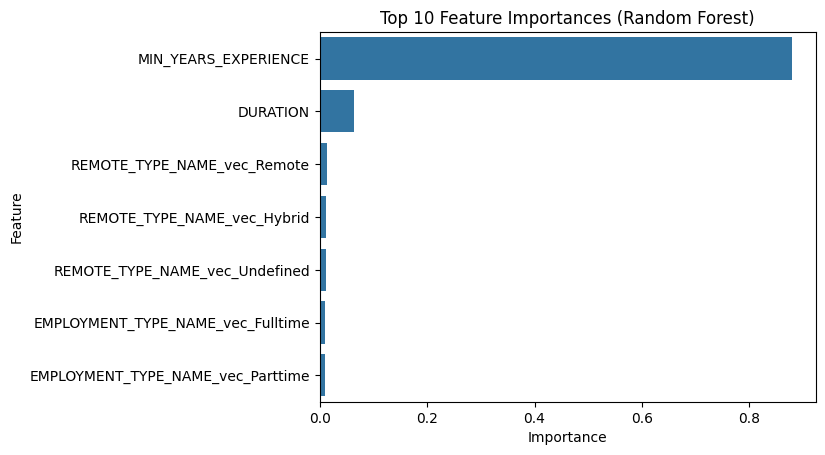

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# feature importances
importances = rf_model.featureImportances.toArray()

# nombres reales (expandido, incluyendo OHE) desde el metadata
meta = regression_data_rf.schema["features_rf"].metadata
attrs = []
for k in ["numeric", "binary"]:
    if k in meta.get("ml_attr", {}).get("attrs", {}):
        attrs += meta["ml_attr"]["attrs"][k]
feature_names = [a["name"] for a in sorted(attrs, key=lambda x: x["idx"])]

print(importances)
print(feature_names)
print(assembler_rf.getInputCols())

# to DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top10 = fi_df.head(10)


# plot
sns.barplot(x="Importance", y="Feature", data=top10)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.savefig("output/rf_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

# Compare 3 Models – GLR, Polynomial, RF (7)

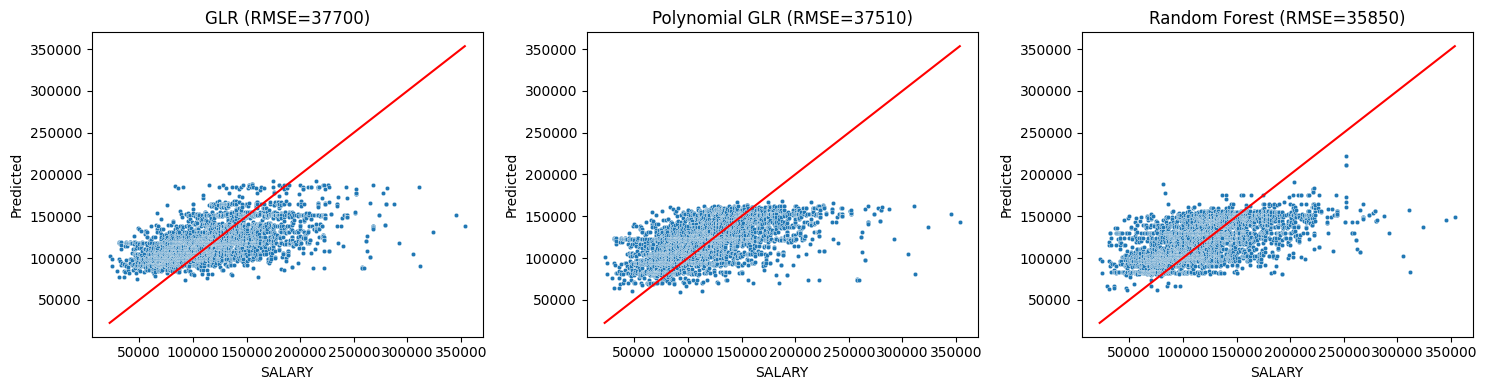

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import os

#Test Predictions
glr_pred  = glr_model.transform(regression_test)
poly_pred = poly_glr_min_years_model.transform(polyreg_test)
rf_pred   = rf_model.transform(rf_test)

# RMSE near or far; close to 0 is ideal
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
rmse_glr  = evaluator.evaluate(glr_pred)
rmse_poly = evaluator.evaluate(poly_pred)
rmse_rf   = evaluator.evaluate(rf_pred)

# AIC / BIC 
def get_aic_bic(model, data):
    n = data.count()
    k = len(model.coefficients) + 1
    aic = model.summary.aic
    bic = aic + (np.log(n) - 2) * k
    return aic, bic

aic_glr, bic_glr = get_aic_bic(glr_model, glr_pred)
aic_poly, bic_poly = get_aic_bic(poly_glr_min_years_model, poly_pred)

# DF  plotting
glr_pd  = glr_pred.select("SALARY", col("prediction").alias("Predicted")).toPandas()
poly_pd = poly_pred.select("SALARY", col("prediction").alias("Predicted")).toPandas()
rf_pd   = rf_pred.select("SALARY", col("prediction").alias("Predicted")).toPandas()

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=glr_pd, x="SALARY", y="Predicted", s=10)
plt.plot(glr_pd["SALARY"], glr_pd["SALARY"], color='red')
plt.title(f"GLR (RMSE={rmse_glr:.0f})")

plt.subplot(1, 3, 2)
sns.scatterplot(data=poly_pd, x="SALARY", y="Predicted", s=10)
plt.plot(poly_pd["SALARY"], poly_pd["SALARY"], color='red')
plt.title(f"Polynomial GLR (RMSE={rmse_poly:.0f})")

plt.subplot(1, 3, 3)
sns.scatterplot(data=rf_pd, x="SALARY", y="Predicted", s=10)
plt.plot(rf_pd["SALARY"], rf_pd["SALARY"], color='red')
plt.title(f"Random Forest (RMSE={rmse_rf:.0f})")

plt.tight_layout()
os.makedirs("_output", exist_ok=True)
plt.savefig("_output/model_comparison_simple.png", dpi=300)
plt.show()

## Comments (7.1)
- The Random Forest model has the lowest RMSE, so it predicts better than the other two models.
- All models show that when the real salary goes up, the predicted one also goes up.
- Some strange points may happen because the models are not perfect and have small inaccuracies, or because some factors that affect salary are not in the data.

## Calculating Log-Likelihood and BIC for PySpark Models    (7.2)

Log Likelihood represents the probability of observing the data given the model parameters. It is used in AIC and BIC calculations.
Log Likelihood is not directly available in PySpark’s GeneralizedLinearRegression model summary. However, you can calculate it using the deviance and the number of observations.


In [17]:
import numpy as np


# Procedure with parameters to calculate Log-Likelihood and BIC
def calc_loglik_bic(model):
    s = model.summary
    n = s.numInstances          # number of observations
    k = len(model.coefficients) + 1
    dev = s.deviance
    disp = s.dispersion

    Log_Likelihood = -0.5 * (n * np.log(2 * np.pi) + n * np.log(disp) + dev / disp)
    bic = k * np.log(n) - 2 * Log_Likelihood
    return Log_Likelihood, bic

# Calculate for GLR and Polynomial GLR with procedure and input parameters
loglik_glr,  bic_glr  = calc_loglik_bic(glr_model)
loglik_poly, bic_poly = calc_loglik_bic(poly_glr_min_years_model)

print(f"GLR -> Log-Likelihood: {loglik_glr:.2f},  BIC: {bic_glr:.2f}")
print(f"Polynomial GLR -> Log-Likelihood: {loglik_poly:.2f},  BIC: {bic_poly:.2f}")

GLR -> Log-Likelihood: -226559.41,  BIC: 453197.63
Polynomial GLR -> Log-Likelihood: -226314.10,  BIC: 452736.56


## Comments
- The Polynomial GLR fits the data slightly better since it has a lower BIC value but both models perform almost equally well.
- Overall, both GLR models provide a good fitbut the Polynomial GLR show a slightly better performance based on its lower BIC value.
